# Pre-processing, Feature Vector Calculations, and Image Reconstruction

In [9]:
import skvideo.io  # pip install sk-video
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tfl
from scipy.ndimage import gaussian_filter1d
from skimage.transform import downscale_local_mean

## Pre-process responses
* load the dF/F responses
* gaussian temporal kernel to smooth
* chop pre/post sections from response traces
* normalize data between -1 and 1, keeping 0 values at 0

In [2]:
# load response data
resp_file = np.load('./data/raw_responses_dfof.npz')
resp_raw = resp_file['responses']
print(resp_raw.shape)

(132, 60, 780)


In [3]:
# filter traces through a gaussian kernel
sigma = 4
resp_gauss = gaussian_filter1d(resp_raw,sigma,axis=2,mode='reflect')
print(resp_gauss.shape)

# chop off pre and post movie presentation frames
resp_chop = resp_gauss[:,:,90:690]
print(resp_chop.shape)

# normalize response between -1 and 1, keeping 0 values at 0
min_val = resp_chop.min()
max_val = resp_chop.max()
abs_max = np.max((np.abs(min_val),np.abs(max_val)))
resp_scaled = ((resp_chop+abs_max)/abs_max) - 1
print(resp_scaled.shape)
print(resp_scaled.min(),resp_scaled.max())

# reshape array into (nCells,nRepeats*nFrames
resp_final = np.reshape(resp_scaled,(resp_scaled.shape[0],resp_scaled.shape[1]*resp_scaled.shape[2]))
print(resp_final.shape)

(132, 60, 780)
(132, 60, 600)
(132, 60, 600)
-0.39051850702147706 1.0
(132, 36000)


In [4]:
# save pre-processed response data
np.savez('./data/response_vectors.npz',response_vectors=resp_final)

## Pre-process movie
* load movie
* crop movie
* normalize values between -1 and 1 (from 0 to 255, where 127 -> 0)
* downscale frames to 32x32

In [5]:
# load movie
video = skvideo.io.vread('./data/touch_of_evil_20s.mp4',as_grey=True)
video_raw_frames = np.reshape(video,video.shape[:3])
print(video_raw_frames.shape)

(600, 720, 1280)


In [6]:
# black buffer of 12 pixels at top and bottom of every frame
# crop frames to get rid of buffer and get centered square of each frame
crop_y = 12
yDim = video_raw_frames.shape[1]-(2*crop_y)
crop_x = (video_raw_frames.shape[2]-yDim)//2
frames_crop = video_raw_frames[:,
                               crop_y:video_raw_frames.shape[1]-crop_y,
                               crop_x:video_raw_frames.shape[2]-crop_x]
print(frames_crop.shape)

# normalize pixel values between [-1,1]
min_val = 0
max_val = 255
frames_norm = (2 * ((frames_crop-min_val)/(max_val-min_val)) ) - 1
print('range of values: ['+str(frames_norm.min())+','+str(frames_norm.max())+']')

# downsample frames to size 32x32
frames = downscale_local_mean(frames_norm,factors=(1,22,22))
print(frames.shape)

# save movie frames as .tiff file
tfl.imsave('./data/processed_movie.tif',frames,bigtiff=True)

(600, 696, 696)
range of values: [-1.0,0.9058823529411764]
(600, 32, 32)


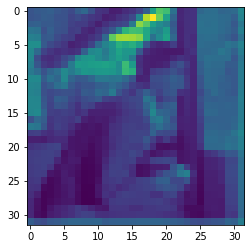

In [10]:
plt.imshow(frames[221,:,:])